Análise e classificação de base de notícias entre Fake news e notícias verídicas. Base disponível em: https://www.kaggle.com/competitions/fake-news

### Importando as bibliotecas:

In [52]:
import spacy
import nltk
from nltk.stem.porter import *
import regex as re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from gensim import downloader
from gensim.models import Word2Vec
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

### Importando os dados:

In [64]:
test = pd.read_csv('test.csv', index_col=0)
train = pd.read_csv('train.csv', index_col=0)

In [3]:
train.head()

title              author  \
id                                                                          
0   House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2                   Why the Truth Might Get You Fired  Consortiumnews.com   
3   15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                 text  label  
id                                                            
0   House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1   Ever get the feeling your life circles the rou...      0  
2   Why the Truth Might Get You Fired October 29, ...      1  
3   Videos 15 Civilians Killed In Single US Airstr...      1  
4   Print \nAn Iranian woman has been sentenced to...      1

### Pré-processamento dos dados:

In [4]:
nlp = spacy.load('en_core_web_sm')

In [5]:
def preprocess (text):

    text = str(text)

    text = text.lower()

    text = nlp(text)

    words = [token.lemma_ for token in text if not token.is_stop and not token.is_punct ]

    return words

train['token_text'] = train['text'].apply(lambda x: preprocess(x))
train['new_text'] = train['token_text'].apply(lambda x: ' '.join(x))
train.drop(columns=['text', 'title', 'author'], axis='columns', inplace=True)

In [6]:
train.to_csv('new_train.csv')

In [7]:
train.head()

label                                         token_text  \
id                                                             
0       1  [house, dem, aide, comey, letter, jason, chaff...   
1       0  [feeling, life, circle, roundabout, head, stra...   
2       1  [truth, fire, october, 29, 2016, \n, tension, ...   
3       1  [video, 15, civilian, kill, single, airstrike,...   
4       1  [print, \n, iranian, woman, sentence, year, pr...   

                                             new_text  
id                                                     
0   house dem aide comey letter jason chaffetz twe...  
1   feeling life circle roundabout head straight l...  
2   truth fire october 29 2016 \n tension intellig...  
3   video 15 civilian kill single airstrike identi...  
4   print \n iranian woman sentence year prison ir...

### Visualização:

In [8]:
#Divisão entre dados fake e não fake
fake = train[train['label'] == 1]
notfake = train[train['label'] == 0]

* Distribuição de frequências

In [39]:
list_fake = []
for i in fake['token_text']:
    for token in i:
        list_fake.append(token)
list_fake = [x.replace(' ', '') for x in list_fake]

list_notfake = []
for k in notfake['token_text']:
    for token in k:
        list_notfake.append(token)
list_notfake = [x.replace(' ', '') for x in list_notfake]

str_fake = ' '.join(list_fake)
str_notfake = ' '.join(list_notfake)

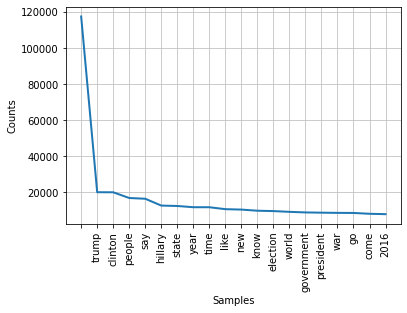

In [44]:
#Fake
freq_fake = nltk.FreqDist(list_fake)
freq_fake.plot(20, cumulative=False)
plt.show()

In [41]:
freq_fake_dc = dict(sorted(freq_fake.items(), key=lambda item: item[1],reverse = True))
for k, v in freq_fake_dc.items(): 
  print(str(k) + ':' + str(v))


:117414
trump:20082
clinton:20046
people:16876
say:16462
hillary:12685
state:12453
year:11774
time:11767
like:10693
new:10458
know:9832
election:9631
world:9208
government:8886
president:8750
war:8640
go:8595
come:8138
2016:7923
country:7635
right:7589
obama:7539
day:7285
work:7183
email:7114
american:7111
report:6859
think:6739
russia:6683
de:6468
way:6400
vote:6397
medium:6392
want:6384
campaign:6219
need:6200
u.s:6104
good:6094
tell:5967
find:5573
take:5569
news:5385
america:5309
donald:5288
thing:5287
support:5222
force:5114
man:5106
political:5103
power:5010
white:5005
look:4991
life:4983
long:4979
include:4919
change:4914
fbi:4898
post:4859
call:4762
united:4730
$:4704
law:4640
party:4580
woman:4517
system:4491
group:4343
military:4340
public:4314
point:4313
million:4304
use:4280
policy:4276
fact:4242
give:4211
help:4197
russian:4178
believe:4107
accord:4093
lead:4007
get:3986
leave:3980
states:3972
house:3968
mean:3963
national:3958
end:3941
great:3906
high:3900
case:3851
try:3

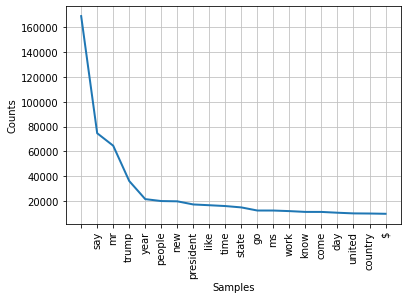

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [45]:
#Not_fake
freq_notfake = nltk.FreqDist(list_notfake)
freq_notfake.plot(20, cumulative=False)

In [43]:
freq_notfake_dc = dict(sorted(freq_notfake.items(), key=lambda item: item[1],reverse = True))
for k, v in freq_notfake_dc.items(): 
  print(str(k) + ':' + str(v))

:168858
say:74610
mr:64570
trump:36150
year:21581
people:20027
new:19813
president:17286
like:16668
time:16000
state:14906
go:12406
ms:12395
work:11932
know:11290
come:11283
day:10634
united:10100
country:9996
$:9777
tell:9768
include:9652
think:9640
take:9592
news:9420
want:9398
government:9192
american:9184
report:8909
house:8908
official:8822
company:8630
states:8422
call:8336
clinton:8293
way:8193
find:7971
woman:7902
group:7901
city:7825
campaign:7740
week:7735
good:7703
man:7610
obama:7598
right:7435
white:7417
law:6956
percent:6833
world:6826
million:6720
national:6621
look:6619
leave:6586
long:6569
york:6558
police:6529
party:6463
write:6403
ask:6399
add:6392
month:6387
help:6365
family:6321
republican:6315
need:6254
accord:6233
case:6230
try:6209
attack:6081
plan:6077
change:6073
political:5953
public:5851
member:5799
twitter:5786
administration:5773
thing:5752
life:5714
school:5691
lead:5663
support:5639
s.:5634
give:5568
court:5564
home:5504
000:5490
follow:5449
get:5425
pol

* Nuvem de Palavras

In [48]:
#fake
wordcloud_fake = WordCloud(background_color='black',colormap='viridis').generate(str_fake)

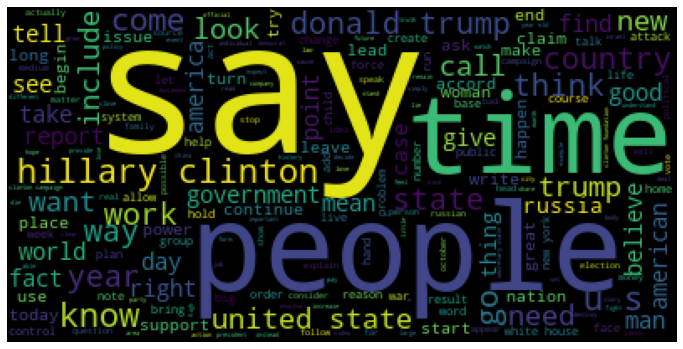

In [49]:
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud_fake)
plt.axis("off")
plt.show()

In [50]:
#não fake
wordcloud_notfake = WordCloud(background_color='black',colormap='hsv').generate(str_notfake)

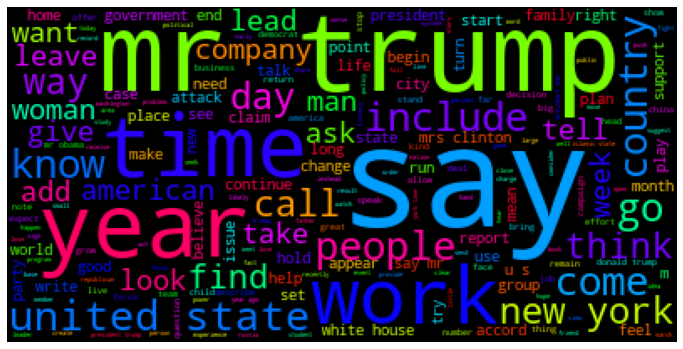

In [51]:
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud_notfake)
plt.axis("off")
plt.show()

### Modelo

* Aplicando Logistic Regression

In [53]:
X = train['new_text']
y = train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

classifier = LogisticRegression()

param_grid = {
             "model__C": [0.01, 1.0, 10],
             "model__class_weight": [None, 'balanced'],
             "model__penalty": ['l1', 'l2'],
             "model__solver": ['liblinear']
             }


pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', classifier)])

grid = GridSearchCV(pipeline,param_grid,n_jobs=-1,cv=fold, scoring= 'roc_auc')
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)

In [54]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3148
           1       0.95      0.95      0.95      3092

    accuracy                           0.95      6240
   macro avg       0.95      0.95      0.95      6240
weighted avg       0.95      0.95      0.95      6240

0.9535256410256411


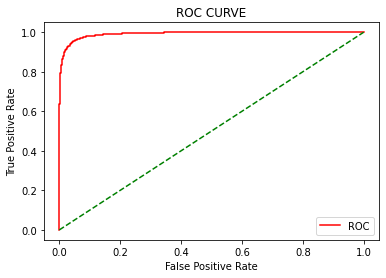

In [55]:
y_proba = grid.predict_proba(X_test)
y_proba = y_proba[:, 1]
fp, tp, thresholds = roc_curve(y_test, y_proba)
plt.plot(fp, tp, color = 'red', label = 'ROC')
plt.plot([0,1], [0,1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()

In [56]:
print(roc_auc_score(y_test, y_proba))

0.9913418610308852


Modelo com Random Forest:


In [57]:
classifier_rf = RandomForestClassifier()

param_grid = {
             "model__n_estimators": [25, 50, 100, 200],
             "model__max_depth": [2,5,10,15,20],
             "model__min_samples_leaf": [2,5,10,15],
             "model__min_samples_split": [2,5,10,15],
             }

pipeline_rf = Pipeline([('tfidf', TfidfVectorizer()),('model', classifier_rf)])

grid_rf = GridSearchCV(pipeline_rf,param_grid,n_jobs=-1,cv=fold, scoring= 'roc_auc')
grid_rf.fit(X_train,y_train)
y_pred_rf = grid_rf.predict(X_test)

In [58]:
print(classification_report(y_test, y_pred_rf))
print(accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3148
           1       0.88      0.89      0.89      3092

    accuracy                           0.89      6240
   macro avg       0.89      0.89      0.89      6240
weighted avg       0.89      0.89      0.89      6240

0.8886217948717948


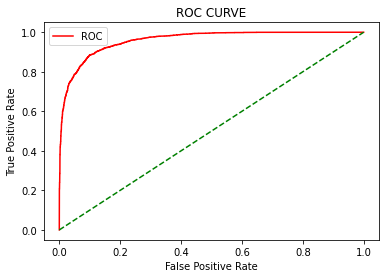

In [59]:
y_proba_rf = grid_rf.predict_proba(X_test)
y_proba_rf = y_proba_rf[:, 1]
fp, tp, thresholds = roc_curve(y_test, y_proba_rf)
plt.plot(fp, tp, color = 'red', label = 'ROC')
plt.plot([0,1], [0,1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()

In [60]:
print(roc_auc_score(y_test, y_proba_rf))

0.9596234328537308


### Aplicando resultado à base de teste do kaggle:

In [65]:
test['token_text'] = test['text'].apply(lambda x: preprocess(x))
test['new_text'] = test['token_text'].apply(lambda x: ' '.join(x))

test['label'] = grid.predict(test['new_text'])

In [ ]:
test.drop(columns=['token_text', 'new_text'], axis='columns', inplace=True)
test.to_csv('new_test.csv')

In [67]:
test.head()

title  \
id                                                         
20800  Specter of Trump Loosens Tongues, if Not Purse...   
20801  Russian warships ready to strike terrorists ne...   
20802  #NoDAPL: Native American Leaders Vow to Stay A...   
20803  Tim Tebow Will Attempt Another Comeback, This ...   
20804                    Keiser Report: Meme Wars (E995)   

                        author  \
id                               
20800         David Streitfeld   
20801                      NaN   
20802            Common Dreams   
20803            Daniel Victor   
20804  Truth Broadcast Network   

                                                    text  label  
id                                                               
20800  PALO ALTO, Calif.  —   After years of scorning...      0  
20801  Russian warships ready to strike terrorists ne...      1  
20802  Videos #NoDAPL: Native American Leaders Vow to...      1  
20803  If at first you don’t succeed, try a different...      0  
20804  42 mins ago 1 Views 0 Comments 0 Likes 'For th...      1